In [9]:
import gzip
import matplotlib.pyplot as plt
plt.style.use("dark_background")

Can I define a sophistication metric? It should be low for random strings and be low for simple string, but increase for structured but interesting strings.

One way to get close to this would be poll a ton of humans on if a given string is interesting to them and try to fit that curve. Another way to approximate might be to use LLMs, but that's simply an internet simulator, so doubt it would be consistent.

The author mentions that kolmogorov complexity on it's own does not satisfy this. Since very random strings have high complexity and very simple string have low which is not the double low we want.

We can approximate kolmogorov complexity as compression (ie gzip length of compressed string)

In [10]:
def k_approx(x: str):
	b = gzip.compress(x.encode())
	return len(b)

simple_string = "a"*26
print(simple_string, k_approx(simple_string))

complex_string = "abcdefghijklmnopqrstuvwxyz"
print(complex_string, k_approx(complex_string))

aaaaaaaaaaaaaaaaaaaaaaaaaa 23
abcdefghijklmnopqrstuvwxyz 46


Clearly it's not quite what we want. But it is for half the inputs. So what if I just take the function and make it piecewise with the inverse of it??

So for the first half of inputs we get K(x) and for the second we do 1/K(x) this way the random ones have low entropy 1/K(x) and the simple strings have K(x)

The question is how do I order the input such that I know which half it should fall under?

What I could do is first compute K(x). If the value is above the theoretical middle point, we take the reciproical, if under, we do nothing. 

So then what is the theoretical midpoint?

The theoretical minimum is the simplest string of all the same letter in the case of shannon entropy this is 0. And in the case where the max shannon entropy is log(n), so if the entropy is under then we can subtract that value from the max.

In [40]:
import math

def count_frequencies(x: str):
    freqs = {}
    for c in x:
        if c in freqs:
            freqs[c] += 1
        else:
            freqs[c] = 1
    return freqs
def entropy(x: str):
    summed = 0.0
    freqs = count_frequencies(x)
    for letter in freqs:
        p = freqs[letter] /len(x)
        summed += p*math.log2(p)
    return -summed

print("aaa", entropy("aaa"))
print("abc", entropy("abc"), math.log2(3))

aaa -0.0
abc 1.584962500721156 1.584962500721156


In [41]:
def soph(x):
	ent = entropy(x)
	max_entropy = math.log2(len(x))
	if ent < max_entropy/2:
		return ent
	else:
		return max_entropy - ent

In [53]:
ascii = lambda i: chr(ord('a') + i)
dist_entropy = []
dist_soph = []
for i in range(26):
    for j in range(26):
        for k in range(26):
            for l in range(26):
                s = ascii(i) + ascii(j) + ascii(k) + ascii(l) 
                dist_entropy.append(entropy(s))
                dist_soph.append(soph(s))

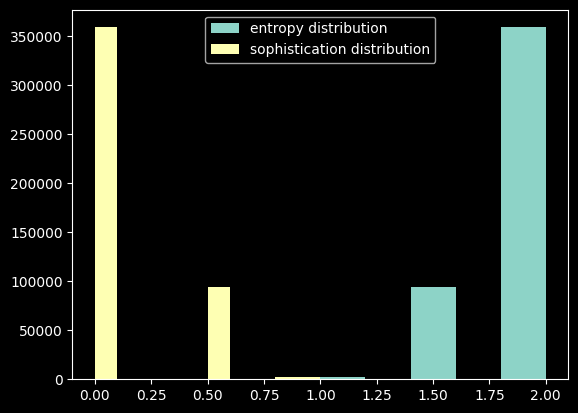

In [56]:
plt.hist(dist_entropy, label="entropy distribution")
plt.hist(dist_soph, label="sophistication distribution")
plt.legend()

To label more sophistcated, I likely should use Gzip since you could think of it as a better compressor than huffman coding.

But I would need to have some general limits of minimums and maximums of gzip which I don't know. But approximately it could look like:

Take most simple string gzip(simple) most complicated string gzip(complicated), then do what I had before

In [65]:
def gzip_soph(x, _min, _most, _max):
	c = k_approx(x)
	if c < _most:
		return c - _min
	else:
		return _max - c

_min = k_approx("aaaaaaaa")
_most = k_approx("abcdabcd")
_max = k_approx("abcdefgh")

print(gzip_soph("a"*8, _min, _most, _max))
print(gzip_soph("abcdabcd", _min, _most, _max))
print(gzip_soph("abcdefgh", _min, _most, _max))

0
2
0


So basically if you know the min complex and max complex and what you think is th most interesting, we can get a sophistication metric. 